Calculation of Implied Volatility

In [79]:
"""
name_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, 

เหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)
ต้องใช้ S0 (ดึง tvdatafeed ได้)
Strike Price ย้อนสูตร black scholes
"""


'\nname_df เก็บชื่อ stocks ไว้ทั้งหมดที่จะใช้ + ราคา S0, \n\nเหลือใส่ black scholes เทียยบราคาจาก vol forecast กับ ราคาจริง(จากimplied Vol)\nต้องใช้ S0 (ดึง tvdatafeed ได้)\nStrike Price ย้อนสูตร black scholes\n'

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
#in case of dw01

import requests
from bs4 import BeautifulSoup
import pandas as pd
url = 'https://www.blswarrant.com/search'
head = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36'

print('0')

html = requests.get(url, headers={'User-Agent': head}).content
df_list = pd.read_html(html)
df_dw01 = df_list[2]
df_dw01['Stock']='SET:' + df_dw01['DW Symbol'].apply(lambda x: x[:-8])
name_df = pd.DataFrame(df_dw01['Stock'].drop_duplicates())
name_df.reset_index(inplace=True)
name_df = name_df.drop(['index'],axis=1)
name_df

0


,Stock
0,SET:DELTA
1,SET:BH
2,SET:TRUE
3,SET:KCE
4,SET:PTTEP
...,...
77,SET:TOP
78,SET:TTB
79,SET:TU
80,SET:VGI


In [82]:
df_dw01 = df_dw01.drop(['Effective Gearing','Sensitivity','Time Decay','Moneyness','Status','Last Trading Date'],axis=1)
df_dw01

,DW Symbol,Imp.Vol.,TTM (days),Stock
0,DELTA01P2408X,88.67%,65,SET:DELTA
1,BH01C2408A,53.96%,65,SET:BH
2,DELTA01C2409A,80.30%,86,SET:DELTA
3,TRUE01C2408A,63.98%,65,SET:TRUE
4,KCE01P2406X,77.37%,25,SET:KCE
...,...,...,...,...
293,VGI01P2408X,80.17%,65,SET:VGI
294,WHA01C2405A,103.06%,5,SET:WHA
295,WHA01C2406A,54.20%,25,SET:WHA
296,WHA01C2408A,54.55%,65,SET:WHA


In [83]:
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

tv = TvDatafeed()
df = tv.get_hist(symbol='SET:SET50', exchange='SET', interval=Interval.in_daily, n_bars=1201)
set50 = df[['close']]
set50.rename(columns = {'close':'remove'}, inplace=True)


In [84]:
for i in range (name_df.shape[0]):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=1201)
    df = df[['close']]
    set50 = pd.merge(set50, df, left_index=True, right_index=True, how='outer')
    set50.rename(columns = {'close':name_df['Stock'][i]}, inplace=True)
set50 = set50.drop('remove',axis=1)

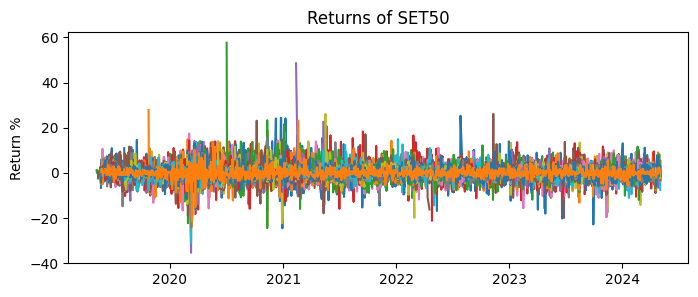

In [85]:
returns = np.log(set50).diff() * 100 #1st difference
plt.figure(figsize=(8,3))
plt.plot(returns)
plt.ylabel("Return %")
plt.title('Returns of SET50');

In [86]:
conclu = name_df[['Stock']]
conclu

,Stock
0,SET:DELTA
1,SET:BH
2,SET:TRUE
3,SET:KCE
4,SET:PTTEP
...,...
77,SET:TOP
78,SET:TTB
79,SET:TU
80,SET:VGI


In [87]:
from arch import arch_model
from sklearn.metrics import mean_squared_error
best_model_list = []
for i in range (name_df.shape[0]):

    returns_individual = returns[[name_df['Stock'][i]]]
    returns_individual = returns_individual.dropna()

    real_vol = []
    for i in range(len(returns)):
        vol = returns_individual[:i].std()
        real_vol.append(vol)

    len_test = int(0.2 * len(returns_individual))
    test_vol = real_vol[-len_test:]

    returns_train, returns_test= returns_individual[:-len_test], returns_individual[-len_test:]

    garch_model_fit = arch_model(returns_train,vol="Garch",p=1,q=1).fit(disp='off',update_freq=len(returns_test))
    arch_model_fit = arch_model(returns_train,vol="ARCH").fit(disp='off',update_freq=len(returns_test))
    gjr_garch_model_fit = arch_model(returns_train,p=1,o=1,q=1).fit(disp='off',update_freq=len(returns_test))
    harch_model_fit = arch_model(returns_train,vol='Harch').fit(disp='off',update_freq=len(returns_test))

    garch_forecast = garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    arch_forecast = arch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    gjr_garch_forecast = gjr_garch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)
    harch_forecast = harch_model_fit.forecast(horizon=len(returns_test),method='analytic',reindex=True)

    garch = garch_forecast.variance.values[-1,:].flatten()
    arch = arch_forecast.variance.values[-1,:].flatten()
    gjr = gjr_garch_forecast.variance.values[-1,:].flatten()
    harch = harch_forecast.variance.values[-1,:].flatten()

    df_test = returns_test.copy()
    df_test['garch']= np.sqrt(garch)
    df_test['arch']= np.sqrt(arch)
    df_test['gjr']= np.sqrt(gjr)
    df_test['harch']= np.sqrt(harch)
    df_test['Vol'] = np.array(test_vol)

    garch_mae = mean_squared_error(df_test['Vol'],df_test['garch'])
    arch_mae = mean_squared_error(df_test['Vol'],df_test['arch'])
    gjr_garch_mae = mean_squared_error(df_test['Vol'],df_test['gjr'])
    harch_mae = mean_squared_error(df_test['Vol'],df_test['harch'])
    mae = [garch_mae,arch_mae,gjr_garch_mae,harch_mae]
    best = mae.index(min(mae))

    if best == 0:
        mod = 'garch'
    elif best == 1:
        mod = 'arch'
    elif best == 2:
        mod = 'gjr'
    elif best == 3:
        mod = 'harch'
    best_model_list.append(mod)

conclu['Suggested Models'] = np.array(best_model_list)

In [88]:
volatility_list_g = []
volatility_list_a = []
volatility_list_gj = []
volatility_list_h = []
for i in range (len(df_dw01)):
    returns_individual = returns[[df_dw01['Stock'][i]]].dropna()
    forecast_model_fit_g = arch_model(returns_individual,vol="Garch", p=1,q=1).fit(disp='off')
    forecast_model_fit_a = arch_model(returns_individual,vol="ARCH").fit(disp='off')
    forecast_model_fit_gj = arch_model(returns_individual,p=1,o=1,q=1).fit(disp='off')
    forecast_model_fit_h = arch_model(returns_individual,vol="Harch").fit(disp='off')
    forecast_g = forecast_model_fit_g.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_a = forecast_model_fit_a.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_gj = forecast_model_fit_gj.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    forecast_h = forecast_model_fit_h.forecast(horizon=df_dw01['TTM (days)'][i],method='analytic',reindex=True)
    
    y = forecast_g.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_g.append(vol6m)

    y = forecast_a.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_a.append(vol6m)

    y = forecast_gj.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_gj.append(vol6m)

    y = forecast_h.variance.values[-1,:].flatten()
    df_y = pd.DataFrame(y)
    df_y.rename(columns={df_y.columns[0]:'forecast'},inplace=True)
    df_y['forecast'] = np.sqrt(df_y['forecast']) * sqrt(250)
    vol6m = float(df_y['forecast'].tail(1))
    volatility_list_h.append(vol6m)
    
df_dw01['Vol_Garch'] = np.array(volatility_list_g)
df_dw01['Vol_Arch'] = np.array(volatility_list_a)
df_dw01['Vol_GJR'] = np.array(volatility_list_gj)
df_dw01['Vol_Harch'] = np.array(volatility_list_h)

In [89]:
summary = pd.merge(df_dw01,conclu,on='Stock')
result = []
for i in range(len(summary)):
    if summary['Suggested Models'][i] == 'garch':
        result.append(summary['Vol_Garch'][i])
    elif summary['Suggested Models'][i] == 'arch':
        result.append(summary['Vol_Arch'][i])
    elif summary['Suggested Models'][i] == 'gjr':
        result.append(summary['Vol_GJR'][i])
    elif summary['Suggested Models'][i] == 'harch':
        result.append(summary['Vol_Harch'][i])

summary['Suggested Model Results'] = np.array(result)
summary['Imp.Vol.'] = summary['Imp.Vol.'].apply(lambda x:x[:-1]).astype(float)

summary['Imp.Vol. - Forecasted Vol.'] = summary['Imp.Vol.'] - summary['Suggested Model Results']
summary


,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770
...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984


In [90]:
#  ต้องเข้าลิงค์แต่ละอันไปเอา strike price https://www.blswarrant.com/mydw/'ชื่อdw'
# หาw,jw
import re
strike = []
for i in range(len(summary)):
    url = 'https://www.blswarrant.com/mydw/' + summary['DW Symbol'][i]
    html = requests.get(url, headers={'User-Agent': head}).content
    soup = BeautifulSoup(html, 'html.parser')
    all_text = soup.get_text()
    pattern = r"Strike \(THB\)\n:\s*([\d,]+\.\d+)"
    match = re.search(pattern, all_text)
    strike_price = match.group(1)
    strike.append(strike_price)
summary['Strike'] = np.array(strike)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651
...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600


In [92]:
#ตอนนมี Vol, K, ขาด S0, C,P , rrf
#S0
Spot = []
df_spot = name_df.copy()
for i in range(len(conclu)):
    df = tv.get_hist(symbol=name_df['Stock'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    s = df['close'][-1]
    Spot.append(s)
df_spot['S'] = np.array(Spot)
summary = pd.merge(summary,df_spot,on='Stock')
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10


In [93]:
#c,p
cp_list = []
for i in range(len(summary)):
    df = tv.get_hist(symbol='SET:' + summary['DW Symbol'][i], exchange='SET', interval=Interval.in_daily, n_bars=2)
    cp = df['close'][-1]
    cp_list.append(cp)
summary['Call/Put'] = np.array(cp_list)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45


In [94]:
#use this code to get risk free rate, however, tradingview data is not updated so input rrf manually for now

rf = tv.get_hist(symbol='ECONOMICS:THINTR', exchange='Central Bank',interval=Interval.in_monthly,n_bars=2)
rrf = rf['close'][-1]
rrf = rrf/100


In [95]:
summary['Strike'] = summary['Strike'].str.replace(',', '').astype(float)

In [100]:
#real cp from imp vol
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Imp.Vol.'][i]/100)**2)/2))*(summary['TTM (days)'][i]/365)))/((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    d2 = d1 - ((summary['Imp.Vol.'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73,P,1.818195,-0.110853
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40,C,10.212646,-2.139207
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53,C,2.966950,-1.435048
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20,C,0.218142,0.177377
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33,P,1.085265,0.153820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36,P,0.049153,0.356052
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01,C,0.009432,0.010000
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12,C,0.035485,0.116314
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45,C,0.287517,0.321886


In [101]:
#Black-Scholes
from scipy.stats import norm
cp_f = []
summary['type'] = summary['DW Symbol'].apply(lambda x: x[-6])
for i in range(len(summary)): #put or call
    d1 = (np.log(summary['S'][i]/summary['Strike'][i]) + ((rrf + (((summary['Suggested Model Results'][i]/100)**2)/2))*(summary['TTM (days)'][i]/365)))/((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    d2 = d1 - ((summary['Suggested Model Results'][i]/100) * np.sqrt(summary['TTM (days)'][i]/365))
    if summary['type'][i] == 'C':
        y = (summary['S'][i] * norm.cdf(d1)) - (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(d2))
    elif summary['type'][i] == 'P':
        y = (summary['Strike'][i] * np.exp(-rrf * (summary['TTM (days)'][i] / 365)) * norm.cdf(-d2)) - (summary['S'][i] * norm.cdf(-d1))
    cp_f.append(y)
summary['Calculated Call/Put'] = np.array(cp_f)
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73,P,8.408534e-01,-0.110853
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40,C,2.539207e+00,-2.139207
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53,C,1.965048e+00,-1.435048
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20,C,2.262270e-02,0.177377
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33,P,1.761803e-01,0.153820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36,P,3.948244e-03,0.356052
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01,C,1.115263e-09,0.010000
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12,C,3.685655e-03,0.116314
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45,C,1.281138e-01,0.321886


In [99]:
#Difference
summary['diff'] = summary['Call/Put'] - summary['Calculated Call/Put']
summary

,DW Symbol,Imp.Vol.,TTM (days),Stock,Vol_Garch,Vol_Arch,Vol_GJR,Vol_Harch,Suggested Models,Suggested Model Results,Imp.Vol. - Forecasted Vol.,Strike,S,Call/Put,type,Calculated Call/Put,diff
0,DELTA01P2408X,88.67,65,SET:DELTA,69.805766,71.456372,67.597513,71.455887,garch,69.805766,18.864234,48.500,70.00,0.73,P,8.408534e-01,-0.110853
1,BH01C2408A,53.96,65,SET:BH,31.079080,30.248882,31.070947,30.248861,harch,30.248861,23.711139,280.076,244.00,0.40,C,2.539207e+00,-2.139207
2,DELTA01C2409A,80.30,86,SET:DELTA,69.807121,71.456372,67.638702,71.455887,garch,69.807121,10.492879,102.000,70.00,0.53,C,1.965048e+00,-1.435048
3,TRUE01C2408A,63.98,65,SET:TRUE,35.504752,35.531234,35.662424,35.531356,arch,35.531234,28.448766,10.500,8.05,0.20,C,2.262270e-02,0.177377
4,KCE01P2406X,77.37,25,SET:KCE,40.356230,48.204442,40.671742,48.204624,garch,40.356230,37.013770,33.651,38.50,0.33,P,1.761803e-01,0.153820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,VGI01P2408X,80.17,65,SET:VGI,44.930437,41.285490,43.469440,41.285535,arch,41.285490,38.884510,1.290,1.75,0.36,P,3.948244e-03,0.356052
294,WHA01C2405A,103.06,5,SET:WHA,23.793378,34.434346,22.779446,34.434355,arch,34.434346,68.625654,6.350,5.10,0.01,C,1.115263e-09,0.010000
295,WHA01C2406A,54.20,25,SET:WHA,25.994154,34.480016,25.044617,34.480029,arch,34.480016,19.719984,6.150,5.10,0.12,C,3.685655e-03,0.116314
296,WHA01C2408A,54.55,65,SET:WHA,28.831318,34.480016,27.894609,34.480029,arch,34.480016,20.069984,5.600,5.10,0.45,C,1.281138e-01,0.321886


In [ ]:
#summary.to_excel('Summary.xlsx')